# Linear Classification and Regression
## An Illustrative Example of Logistic Regression Regularization

## Libraries imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
#sharper plots
%config InlineBackend.figure_format = 'retina'


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

## Data imports

In [5]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = '../../data/'

# loading data
data = pd.read_csv(
    DATA_PATH + 'microchip-tests.txt',
    header=None,
    names=('test1', 'test2', 'released')
)
# getting some info about dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   test1     118 non-null    float64
 1   test2     118 non-null    float64
 2   released  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


In [6]:
data.head(5)

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [79]:
X = data.iloc[:, :2]
y = data.iloc[:, 2]

X.head()

,test1,test2
0,0.051267,0.69956
1,-0.092742,0.68494
2,-0.213710,0.69225
3,-0.375000,0.50219
4,-0.513250,0.46564


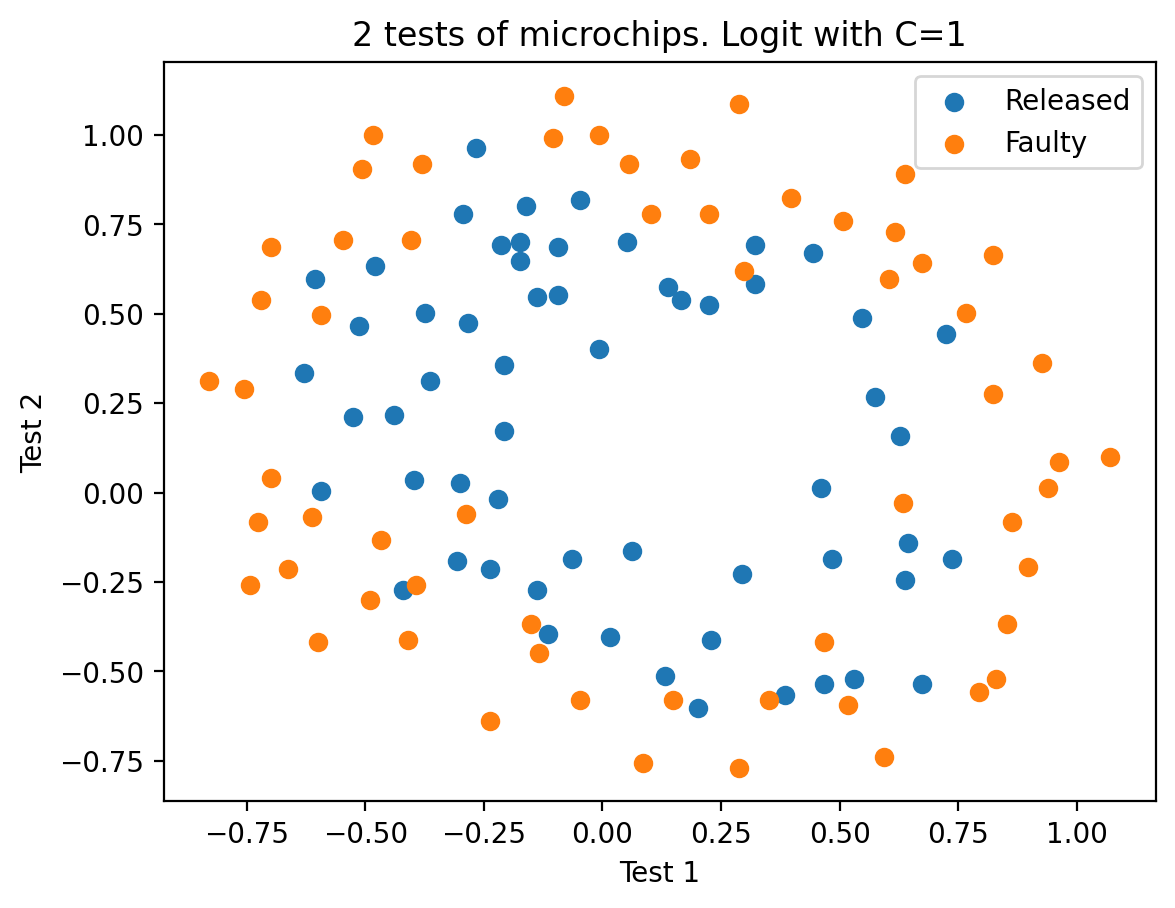

In [80]:
plt.scatter(X.iloc[y[y == 1].index, 0], X.iloc[y[y == 1].index, 1], c="tab:blue", label="Released")
plt.scatter(X.iloc[y[y == 0].index, 0], X.iloc[y[y == 0].index, 1], c="tab:orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=1")
plt.legend();

In [96]:
# Let’s define a function to display the separating curve of the classifier.
def plot_boundary(clf, X, y, grid_step=0.01, poly_featurizer=None):
    x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:, 0].max() + 0.1
    y_min, y_max = X.iloc[:, 1].min() - 0.1, X.iloc[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step), np.arange(y_min, y_max, grid_step)
    )

    # to every point from [x_min, m_max]x[y_min, y_max]
    # we put in correspondence its own color
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X.iloc[y[y == 1].index, 0], X.iloc[y[y == 1].index, 1], c="tab:blue", label="Released")
    plt.scatter(X.iloc[y[y == 0].index, 0], X.iloc[y[y == 0].index, 1], c="tab:orange", label="Faulty")
    

We define the following polynomial features of degree for two variables:

$$
    \left\{x_1^3 x_1^0, x_1^2 x_1^1, x_1^1 x_1^2, x_1^0 x_1^3 \right\}
    = \left\{x_1^i x_1^j \right\}_{i + j = d, i,j \in N}
$$

for $d = 3$:

$$
    1, x_1, x_2, x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3
$$

In [87]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X.values)
X_poly.shape

(118, 36)

In [88]:
pd.DataFrame(X_poly).head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.008589,0.117206,9.308192e-10,1.270142e-08,1.733163e-07,0.000002,0.000032,0.000440,0.006009,0.081993
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,-0.013981,0.103256,-5.901130e-08,4.358241e-07,-3.218751e-06,0.000024,-0.000176,0.001297,-0.009576,0.070724
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,-0.033973,0.110047,-2.035982e-05,6.594958e-05,-2.136241e-04,0.000692,-0.002241,0.007260,-0.023518,0.076180
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,-0.011978,0.016040,-1.042843e-03,1.396547e-03,-1.870219e-03,0.002505,-0.003354,0.004492,-0.006015,0.008055
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,-0.011235,0.010193,-9.382157e-03,8.511851e-03,-7.722277e-03,0.007006,-0.006356,0.005766,-0.005232,0.004746


Let’s train logistic regression with regularization parameter

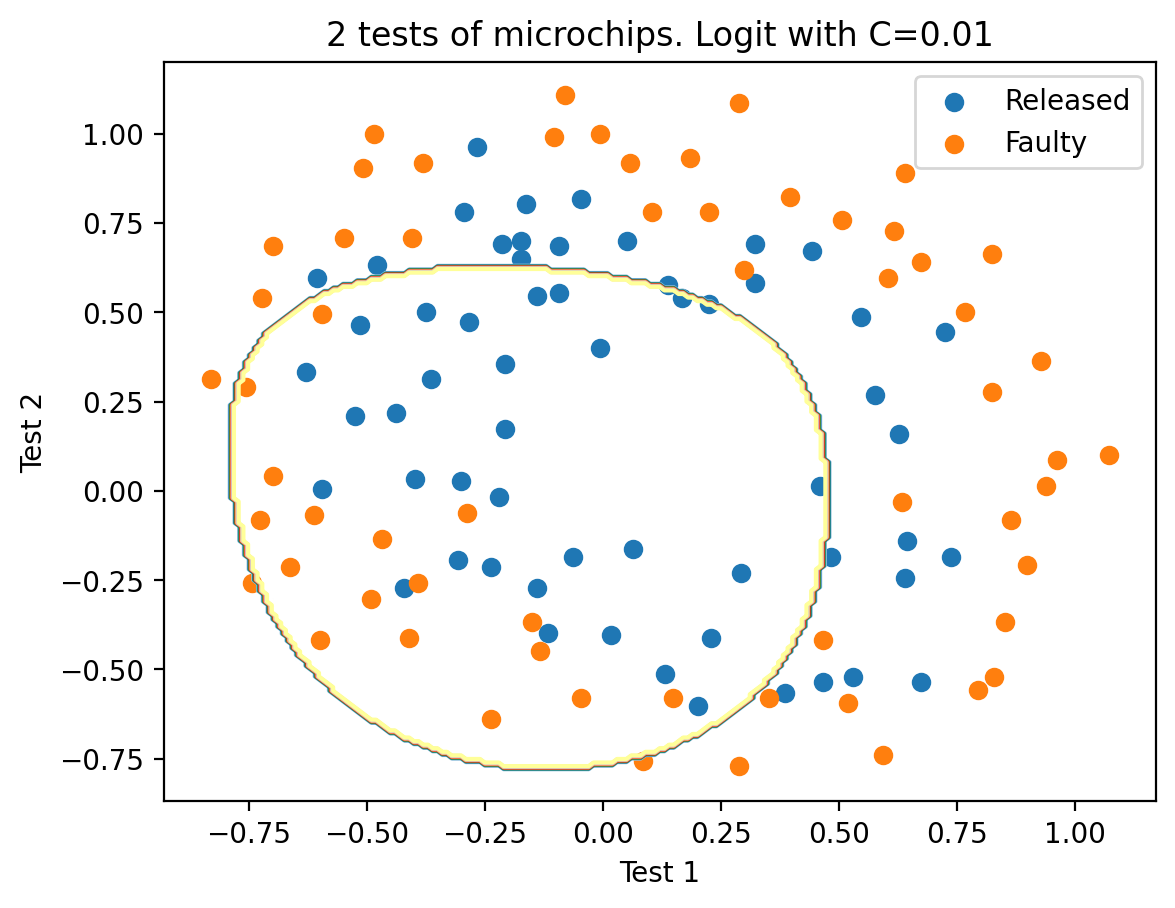

In [97]:
%%capture --no-display

C = 1e-2
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.01, poly_featurizer=poly)

#plt.scatter(X.iloc[y[y == 1].index, 0], X.iloc[y[y == 1].index, 1], c="tab:blue", label="Released")
#plt.scatter(X.iloc[y[y == 0].index, 0], X.iloc[y[y == 0].index, 1], c="tab:orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()
plt.show()

In [49]:
print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

Accuracy on training set: 0.508


We could now try increasing to 1. In doing this, we weaken regularization, and the solution can now have greater values (in absolute value) of model weights than previously. Now the accuracy of the classifier on the training set improves to 0.831.

Accuracy on training set: 0.831


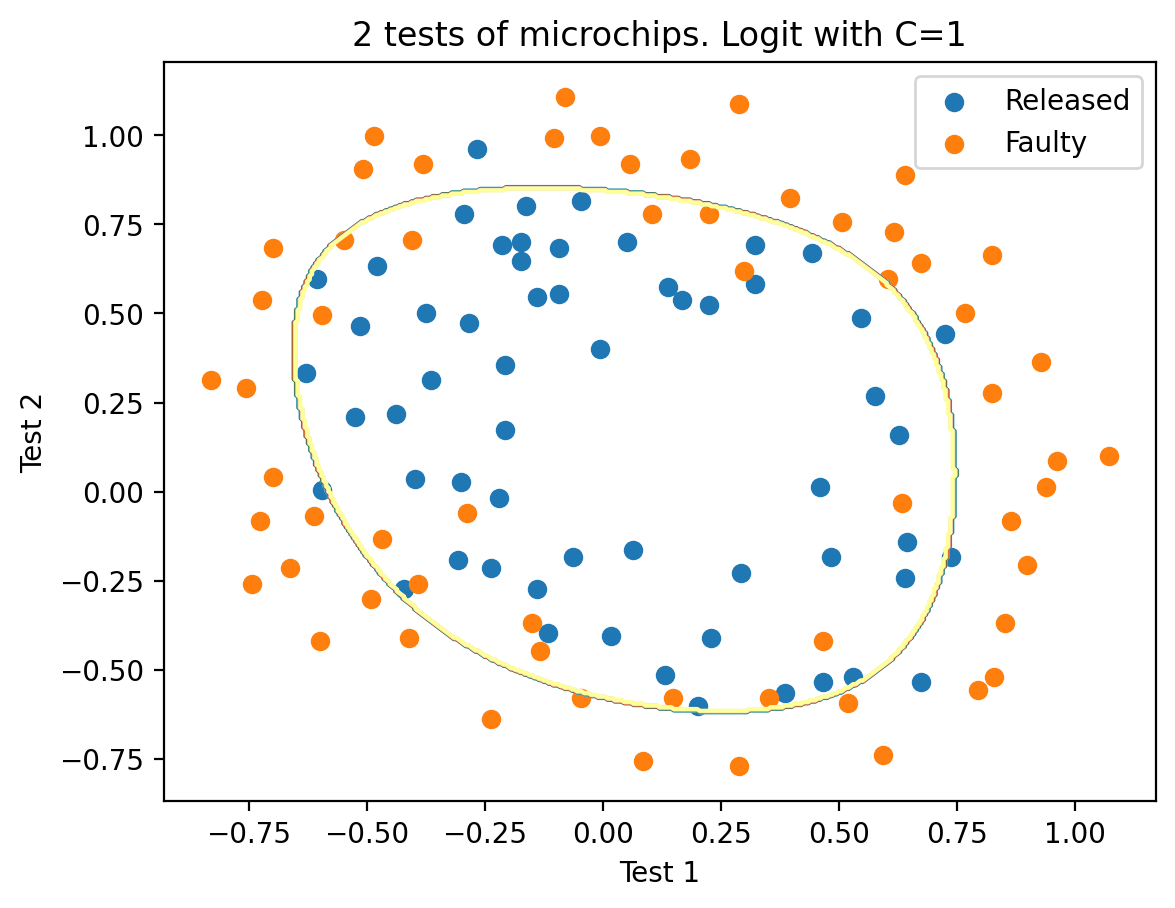

In [99]:
C = 1
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.005, poly_featurizer=poly)

#plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
#plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

Then, why don’t we increase C even more - up to 10,000? Now, regularization is clearly not strong enough, and we see overfitting. Note that, with 
=1 and a “smooth” boundary, the share of correct answers on the training set is not much lower than here. But one can easily imagine how our second model will work much better on new data.

/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on training set: 0.873


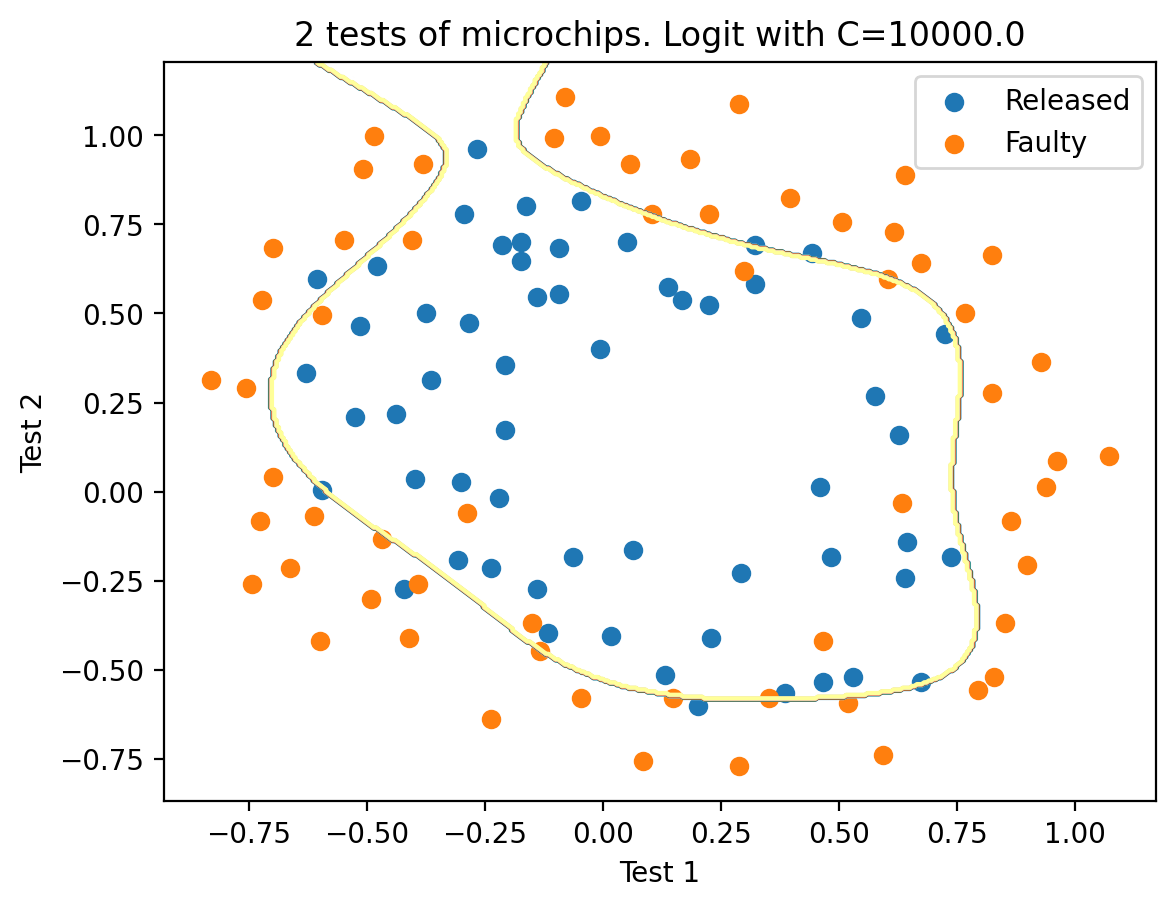

In [101]:
C = 1e4
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.005, poly_featurizer=poly)

#plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
#plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

## Regularization parameter tuning

In [102]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, n_jobs=-1)
logit_searcher.fit(X_poly, y);

In [103]:
logit_searcher.C_

array([143.98479529])

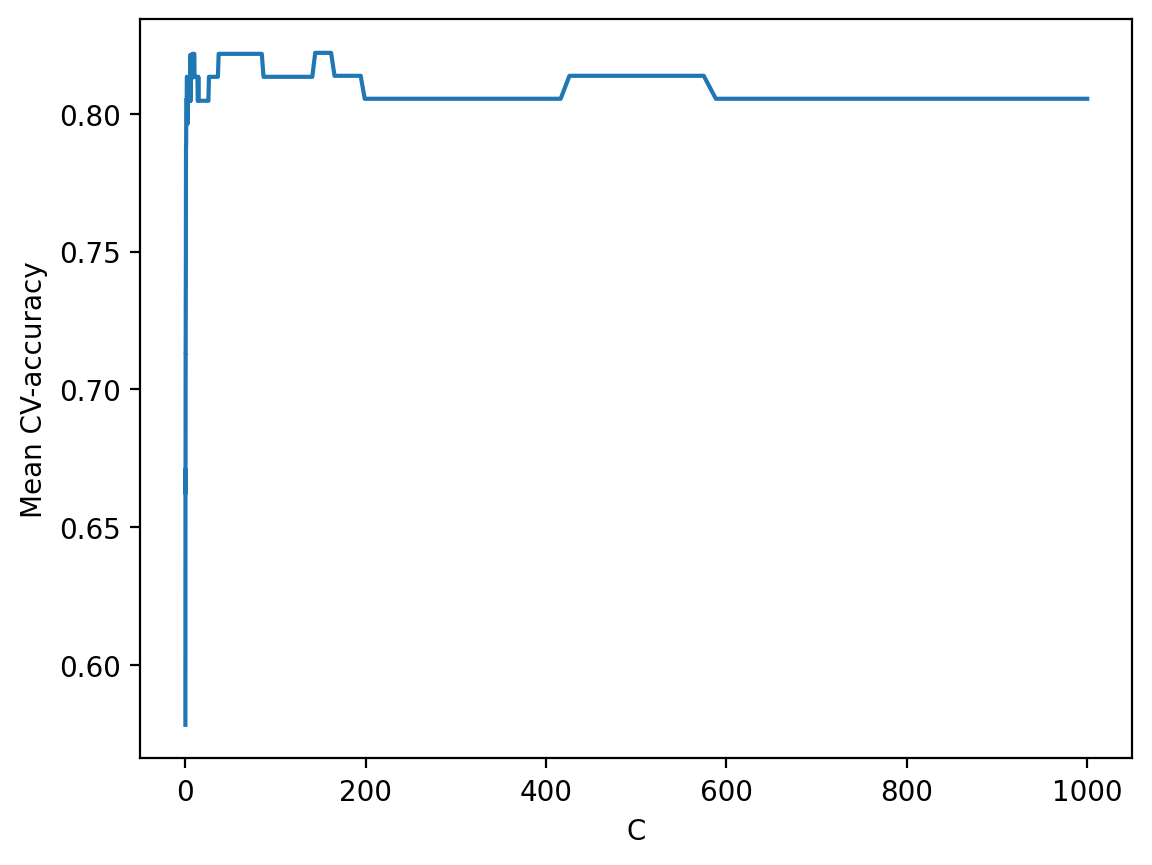

In [104]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel("C")
plt.ylabel("Mean CV-accuracy");

Finally, select the area with the “best” values of C.

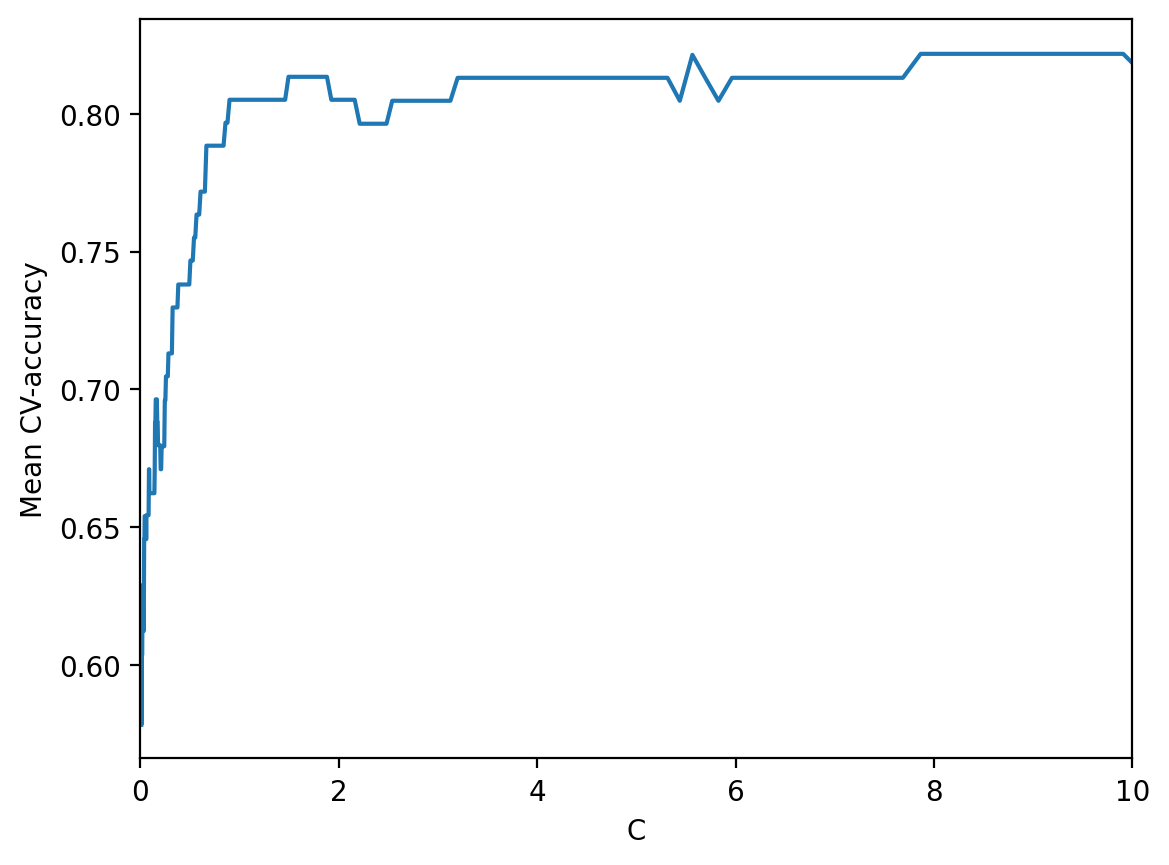

In [105]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel("C")
plt.ylabel("Mean CV-accuracy")
plt.xlim((0, 10));

Recall that these curves are called validation curves. Previously, we built them manually, but sklearn has special methods to construct these that we will use going forward.